#RNN-модель для генерации текста с помощью Tensorflow и Keras

##Импорты

Для обучения воспользуемся [датасетом](https://www.kaggle.com/datasets/lizakonopelko/disco-elysium-dialogue-texts), состоящим из всего текста игры Disco Elysium

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

### Воспользуемся MirriredStrategy, чтобы использовать все GPU
Информация взята отсюда -> [link](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/distributed_training.ipynb)

In [2]:
strategy = tf.distribute.MirroredStrategy()

# Предобработка данных
После загрузки данных необходимо обработать текст путем приведения его в нижний регистр и удаления лишних отступов

In [3]:
df = pd.read_csv('/content/texts_extracted.csv', header=None, sep='\t')
df.rename(columns={0: "text"}, inplace=True)
df['text'] = df['text'].str.replace('"', '')
df['text'] = df['text'].str.replace("'", '')
df.head()

,text
0,88... This elevator was maintained a long time...
1,A man my age? What are you implying? Im at the...
2,A science person? He snarls. The *so-called* s...
3,"A slow, sad song started playing. Like organ m..."
4,"After life, death -- after death, life again. ..."


In [4]:
dataset = df['text']
corpus = []
with strategy.scope():
    for line in dataset:
        lowercase_line = line.lower()
        corpus.append(lowercase_line)

##Токенизация текста

Далее мы инициализируем токенизатор и подгоним под него наши данные. Токенизатор присваивает каждому слову числовое значение. Это необходимо для дальнейших вычислений

In [5]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

In [6]:
word_to_token = tokenizer.word_index

In [7]:
def key_pair(num):
    count=0
    for key, value in word_to_token.items():
        if count>=num: break
        print(f''''{key:}': {value},''')
        count +=1
key_pair(10)

total_words = len(word_to_token)+1
print('\nКоличество токенов: ',total_words)

'the': 1,
'you': 2,
'a': 3,
'to': 4,
'i': 5,
'of': 6,
'it': 7,
'and': 8,
'in': 9,
'is': 10,

Количество токенов:  23918


##Преобразование в n-граммы
Мы хотим предсказать слово по первым нескольким словам предложения. Для этого необходимо соответствующим образом подготовить наши данные.

Для этого мы преобразуем каждое предложение в n-граммы. Это означает разбиение предложения на последовательности с указанием последнего слова в качестве цели в виде:
$$
P(A_1, ..., A_n) = P(A_n| A_{n-1}, ..., A_1)* P(A_{n-1}| A_{n-2}, ..., A_1)*...*P(A_1)
$$


In [8]:
input_sequences = []
with strategy.scope():
    for line in corpus:
        token_list = tokenizer.texts_to_sequences([line])[0]
        for i in range(1, len(token_list)):
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

После преобразования предложения будут выглядеть таким образом:

In [9]:
input_sequences[:5]

[[8923, 12],
 [8923, 12, 2472],
 [8923, 12, 2472, 31],
 [8923, 12, 2472, 31, 6465],
 [8923, 12, 2472, 31, 6465, 3]]

In [10]:
before = input_sequences[1]
max_seq_len = max(len(x) for x in input_sequences)

### Padding
Созданные n-граммы не обладают одинаковой длиной, что необходимо для дальнейших вычислений. Чтобы все последовательности соответствовали одинаковой длине, необходимо дополнить последовательности нулевыми значениями.

In [11]:
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_seq_len, padding = 'pre'))

In [12]:
after = input_sequences[1]

В результате последовательности будут иметь следующий вид:

In [13]:
print(f'До: {before}')
print(f'\nПосле: {after}')

До: [8923, 12, 2472]

После: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 8923   12 2472]



После подготовки корпуса нужно создать набор данных, состоящий из пар "feature-label". Этот набор понадобится для обучения модели

In [14]:
features, labels = input_sequences[:, :-1], input_sequences[:, -1],
labels = tf.keras.utils.to_categorical(labels, num_classes=total_words)

Чтобы не столкнуться с проблемой нехватки памяти уменьшим объем используемых данных до одной трети

In [15]:
with strategy.scope():
    n = 0.01
    slice_size = int(len(features)*n)
    features=  features[:slice_size, :]
    labels = labels[:slice_size, :]

# Создание модели
Модель будет выполнять следующий алгоритм:


1.   Встраивание последовательностей векторы
2.   Обработка с помощью LSTM-слоя
3.   Предсказание следующего слова, используя выходной слой с функцией активации Softmax


In [16]:
#Create the model!
def generator_model():
    tf.random.set_seed(42)
    model = Sequential()
    model.add(Embedding(total_words, 100, input_length = max_seq_len-1)),
    model.add(Bidirectional(LSTM(64, return_sequences = True))),
    model.add(Bidirectional(LSTM(32))),
    model.add(Dense(64, activation = 'relu')),
    model.add(Dense(total_words, activation = 'softmax'))
    return model


In [17]:
with strategy.scope():
    model = generator_model()
    model.compile(loss = 'categorical_crossentropy',
                 optimizer = tf.keras.optimizers.Adam(learning_rate = 0.002),
                 metrics = ['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 76, 100)           2391800   
                                                                 
 bidirectional (Bidirection  (None, 76, 128)           84480     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 23918)             1554670   
                                                                 
Total params: 4076326 (15.55 MB)
Trainable params: 40763

### Trainging the Model

In [19]:
EPOCHS = 20
history = model.fit(features, labels, epochs = EPOCHS)

Epoch 1/20
252/252 [==============================] - 37s 96ms/step - loss: 7.5632 - accuracy: 0.0490
Epoch 2/20
252/252 [==============================] - 10s 41ms/step - loss: 6.4702 - accuracy: 0.0506
Epoch 3/20
252/252 [==============================] - 9s 36ms/step - loss: 6.2269 - accuracy: 0.0514
Epoch 4/20
252/252 [==============================] - 9s 35ms/step - loss: 6.0462 - accuracy: 0.0509
Epoch 5/20
252/252 [==============================] - 8s 32ms/step - loss: 5.9068 - accuracy: 0.0531
Epoch 6/20
252/252 [==============================] - 8s 30ms/step - loss: 5.7928 - accuracy: 0.0564
Epoch 7/20
252/252 [==============================] - 8s 31ms/step - loss: 5.6945 - accuracy: 0.0596
Epoch 8/20
252/252 [==============================] - 8s 32ms/step - loss: 5.5887 - accuracy: 0.0624
Epoch 9/20
252/252 [==============================] - 8s 31ms/step - loss: 5.4769 - accuracy: 0.0735
Epoch 10/20
252/252 [==============================] - 8s 31ms/step - loss: 5.3610 - accu

Графики точности и loss-функции

In [ ]:
def plot_graph(history, string):
    plt.plot(history.history[string])
    plt.xlabel('Эпохи')
    plt.ylabel(string)
    plt.show()

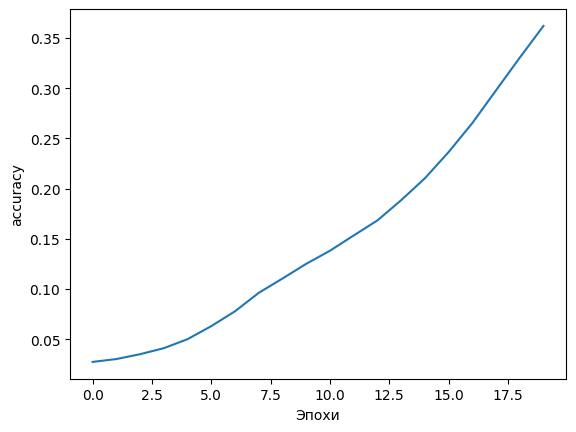

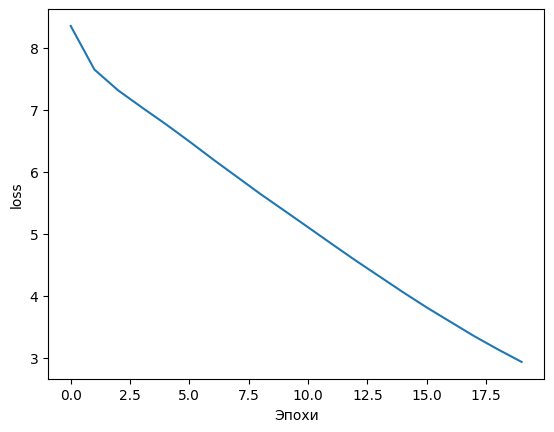

In [ ]:
plot_graph(history, 'accuracy')
plot_graph(history, 'loss')

## Генерация текста

In [20]:
def test_generator(string, num):
    if len(string)==0:
        print('')
        return
    for _ in range(num):
        token_list = tokenizer.texts_to_sequences([string])[0]
        token_list = pad_sequences([token_list], maxlen=max_seq_len-1, padding = 'pre')
        probabilities = model.predict(token_list)
        choice = np.random.choice([1,2,3])
        predicted = np.argsort(probabilities, axis = -1)[0][-choice]
        if predicted !=0:
            generated_word = tokenizer.index_word[predicted]
            string += " " + generated_word
    print(string)

Проверка

In [25]:

#@markdown **Введение промта и требуемого количества слов**
promt = "you" #@param {type: "string"}
seq_length = 10 #@param {type: "integer"}
test_generator(promt, seq_length)

1/1 [==============================] - 0s 67ms/step
you do a lieutenant man of barely clinging he man is
